In [2]:
# from pgmpy.inference import VariableElimination
# from pgmpy.models import BayesianNetwork
import math
import scipy as sp
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import time
from statsmodels.tsa.stattools import grangercausalitytests

import os,sys
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from numpy import array
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import tensorflow as tf
import joblib
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import multiprocessing
import seaborn as sns
import traceback
import glob
#import bnlearn as bn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from collections import OrderedDict
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

In [3]:
class KnnModelTrain:
    '''
    Attributes
    ----------------------------------------------------------------------------
    input_path : Pandas DataFrame
        -> Path of the full csv file
    akm_to_model_path : str
        -> Path of the akm_to_model for KNN csv file
    logfile_path
        -> Path where logfile to be stored
    model_path
        -> Path where trained KNN models/jsons to be stored
    independent_features
        -> List of independent features for training
    target_feature
        -> Target feature name

    Methods
    ----------------------------------------------------------------------------
    readcsv(file)
        -> It reads csv and return dataframe with sorted values by AKM and REPORT_DATE

    getakmdata(fulldf,ad,kw,mt)
        -> It returns dataframe for the given akm values from the fulldf

    isEnoughData(df,columns)
        -> It return True/False based on distinct value count of the target feature
    
    computeSMAPENoExp(act,pred)
        -> It returns smape value from the from the actual and predicted values

    buildLaggedData(akm,akmdf,features,target, maxlag)
        -> It returns dictionary of LagToData and LagToFeatures 
        LagToData ->  It will have Lag as key and corresponding dataframe as value
        LagToFeatures ->It will have Lag as key and corresponding feature list as value

    trainModelAndLOOCVTest(akm,LagToData,LagToFeatures,target,objective,successfile)
        -> It returns Best lag dataframe, Best lag value and Best lag features list
        
    pyplotscatter(akm,target,actual,predicted,setrange)
        -> It will plot scattered plot of actual and predicted values with regression line

    get_stats(df,feature)
        -> It will return  dictionary of 'min','max','mean' and 'std' value of the target feature

    serialize_model(model,root_path,AD_GROUP_ID,KEYWORD_ID,MATCH_TYPE)
        -> It will serialize model for the given AKM combination and store it at root_path

    serialize_akm_metadata(args)
        -> It will store akm metadata as json in binary format.

    finalKNNModelTrainAndTest(akm,bestLag,bestLagData,bestFeatures,target,testsize,successfile)
        -> it will train KNN model on 80% data and test on 20% data and returns dictionary of 
           'bestLag' ,'smapedatalength', 'skippedcnt', 'testsmape'

    finalKNNModel(bestLagData,bestFeatures,target)
        -> It will return trained KNN model object on 100% data

    trainModels(input_path,akm_to_model_path,logfile_path,model_path)
        -> It will train models for each AKM combinatiion from the akm_to_model file and store it at given path

    '''
    def __init__(self,input_path,akm_to_model_path,logfile_path,model_path,independent_features,target_feature,max_lag,knnweight):
        self.input_path = input_path
        self.akm_to_model_path = akm_to_model_path
        self.logfile_path = logfile_path
        self.model_path = model_path
        self.independent_features = independent_features #independent features
        self.target_feature = target_feature
        self.max_lag = max_lag
        self.todays_date = datetime.now()
        self.knnweight = knnweight
        
    def readcsv(self,file):
        '''
        Args:
            file -> Input file path to read csv file
        Returns:
            It reads csv and return dataframe with sorted values by AKM and REPORT_DATE
        '''
        fullakmdf = pd.read_csv(file,parse_dates=['REPORT_DATE'])
        fullakmdf.sort_values(by=['AD_GROUP_ID','KEYWORD_ID','MATCH_TYPE','REPORT_DATE'])
        return fullakmdf

    def getakmdata(self,fulldf,ad,kw,mt):
        '''
        Args:
            fulldf -> full dataframe with all akms
            ad -> AD_GROUP_ID value
            kw -> KEYWORD_ID value
            mt -> MATCH_TYPE value
        Returns:
            Return dataframe for the given akm combination
        '''
        akmdf = fulldf.loc[(fulldf['AD_GROUP_ID'] == ad) & (fulldf['KEYWORD_ID'] == kw) & (fulldf['MATCH_TYPE'] == mt)].reset_index(drop=True)
        akmdf = akmdf.sort_values(by=['REPORT_DATE']).reset_index(drop=True)
        return akmdf

    def isEnoughData(self,df,columns):
        '''
        Args:
            df -> input dataframe
            columns -> target feature name(list)
        Returns:
            It return True/False based on distinct value count of the target feature
        '''
        for col in columns:
            distcnt = np.count_nonzero(df[col], axis=0)
            if (distcnt < 10):
                return False
            # sd = df[col].std()
        return True

    def computeSMAPENoExp(self,act,pred):
        '''
        Args :
            act -> array/series/list of actual values 
            pred -> array/series/list of predicted values
        Returns :
            It return symetric mean absolute percentage error

        Assumption: actuals and predictions are not logarithms
        '''
         
        #Assumption: actuals and predictions are not logarithms
        smape = 0
        skippedcnt = 0
        for a,p in zip(act,pred):
            den = abs(a) + abs(p)
            if (den > 0):
                num = 2*abs(p-a)
            else:
                den = 1
                num = 2*abs(p-a)
                skippedcnt += 1
                
            smape += (num/den)
        
        smape = (100*smape)/len(act)
        smapedatalength = len(act)
                            
        return smapedatalength, skippedcnt, round(smape,2)

    def buildLaggedData(self,akm,akmdf,features,target, maxlag):
        '''
        Args:
            akm -> akm string 
            akmdf -> akm dataframe
            features -> independent feature list
            target -> target feature name
            maxlag -> maxlag value
        Returns:
            -> It returns dictionary of LagToData and LagToFeatures 
            LagToData ->  It will have Lag as key and corresponding dataframe as value
            LagToFeatures ->It will have Lag as key and corresponding feature list as value
        '''
        LagToData = OrderedDict()
        LagToFeatures = OrderedDict()
        
        for lag in range(1,maxlag+1,1):
            if (lag == 1):
                #for first lag, create new dataframe and add target column data
                df = pd.DataFrame()
                df[target] = akmdf[target]
                newfeatures = []
            else:
                #for other lags lag, start with the previous lag's data
                df = LagToData[lag-1].copy(deep=True)
                newfeatures = [x for x in LagToFeatures[lag-1]]
            
            #Create lagged features for the given features
            for col in features:
                newcol = col+'_lag'+str(lag)
                df[newcol] = akmdf[col].shift(lag)
                newfeatures.append(newcol)
            
            #create lagged features for the target
            newcol = target+'_lag'+str(lag)
            df[newcol] = akmdf[target].shift(lag)
            newfeatures.append(newcol)
            
            #delete first row because it has missing features from lagging.
            #This is cumulative for the new DFs for new lags
            df = df.iloc[1:,:]
            
            #Add data and feature names to the dictionary
            LagToData[lag] = df
            LagToFeatures[lag] = newfeatures
            
        return LagToData, LagToFeatures

    def trainModelAndLOOCVTest(self,akm,LagToData,LagToFeatures,target,objective,successfile):
        '''
        Args:
            akm -> akm string
            LagToData -> Dictionary with Lag as key and corresponding dataframe as value
            LagToFeatures -> Dictionary with Lag as key and corresponding Lag features as value
            target -> target feature name
            objective -> smape or r2
            successfile -> logfile
        Returns:
            It returns Best lag dataframe, Best lag value and Best lag features list
        '''
        #while strictly not necessary, assuming ordered dictionary for aesthetic reasons
        bestsmape = 1000000
        bestlag = 0
        bestsmapeskippedcnt = 0
        bestsmapedatalength = 0
        bestr2 = -1000000
        
        if (objective == 'smape'):
            for lag, df in LagToData.items():
                if (len(df.index) < 30):
                    print('Skipping modeling of lag = '+ str(lag) + 'for ' + akm + ' because numrows < 30')
                    continue

                features = LagToFeatures[lag]

                X = df[features].to_numpy()
                y = df[target].to_numpy()

                loo = LeaveOneOut()
                act = []
                pred = []
                for train_index, test_index in loo.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]            
                    knn = KNeighborsRegressor(n_neighbors=5,weights=self.knnweight)
                    knn.fit(X_train,y_train)
                    y_test_pred = knn.predict(X_test)
                    #Assumption: LOOCV ==> only one element in the test data
                    #remember log(z+1) has been done on target
                    pred.append(math.exp(y_test_pred[0])-1)
                    act.append(math.exp(y_test[0])-1)

                smapedatalength, skippedcnt, smape = self.computeSMAPENoExp(act,pred)
                r2 = round(r2_score(act,pred),2)

                #Using SMAPE as the the criterion which must be minimized
                if (smape < bestsmape):
                    bestsmape = smape
                    bestlag = lag
                    bestsmapeskippedcnt = skippedcnt
                    bestsmapedatalength = smapedatalength
                    bestr2 = r2

            bestlagdatalength = len(LagToData[bestlag].index)
            lag1datalength = len(LagToData[1].index)
            print('AKM\ttarget\tbestSMAPE\tr2\tskippedcnt\tdatalength\tlag = '+akm+'\t'+target+'\t'+str(bestsmape)+'\t'+str(bestr2)+'\t'+str(bestsmapeskippedcnt)+'\t'+str(smapedatalength)+'\t'+str(bestlag))
            successfile.write('AKM\ttarget\tbestSMAPE\tr2\tskippedcnt\tdatalength\tlag = '+akm+'\t'+target+'\t'+str(bestsmape)+'\t'+str(bestr2)+'\t'+str(bestsmapeskippedcnt)+'\t'+str(smapedatalength)+'\t'+str(bestlag)+'\n')
            successfile.flush()
            return LagToData[bestlag], bestlag, LagToFeatures[bestlag]
        
        #objective is r2
        else:
            for lag, df in LagToData.items():
                if (len(df.index) < 30):
                    print('Skipping modeling of lag = '+ str(lag) + 'for ' + akm + ' because numrows < 30')
                    continue

                features = LagToFeatures[lag]

                X = df[features].to_numpy()
                y = df[target].to_numpy()

                loo = LeaveOneOut()
                act = []
                pred = []
                for train_index, test_index in loo.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]            
                    knn = KNeighborsRegressor(n_neighbors=5,weights=self.knnweight)
                    knn.fit(X_train,y_train)
                    y_test_pred = knn.predict(X_test)
                    #Assumption: LOOCV ==> only one element in the test data
                    #remember log(z+1) has been done on target
                    pred.append(math.exp(y_test_pred[0])-1)
                    act.append(math.exp(y_test[0])-1)

                smapedatalength, skippedcnt, smape = self.computeSMAPENoExp(act,pred)
                r2 = round(r2_score(act,pred),2)

                #Using r2 as the the criterion which must be maximized
                if (r2 > bestr2):
                    bestsmape = smape
                    bestlag = lag
                    bestsmapeskippedcnt = skippedcnt
                    bestsmapedatalength = smapedatalength
                    bestr2 = r2

            bestlagdatalength = len(LagToData[bestlag].index)
            lag1datalength = len(LagToData[1].index)
            
            print('AKM\ttarget\tSMAPE\tbestr2\tskippedcnt\tdatalength\tlag = '+akm+'\t'+target+'\t'+str(bestsmape)+'\t'+str(bestr2)+'\t'+str(bestsmapeskippedcnt)+'\t'+str(smapedatalength)+'\t'+str(bestlag))
            successfile.write('AKM\ttarget\tSMAPE\tbestr2\tskippedcnt\tdatalength\tlag = '+akm+'\t'+target+'\t'+str(bestsmape)+'\t'+str(bestr2)+'\t'+str(bestsmapeskippedcnt)+'\t'+str(smapedatalength)+'\t'+str(bestlag)+'\n')
            successfile.flush()
            return LagToData[bestlag], bestlag, LagToFeatures[bestlag]

    def pyplotscatter(self,akm,target,actual,predicted,setrange):
        '''
        Args:
            akm -> akm string 
            target -> target feature name
            actual -> list/array ofactual values
            predicted -> list/array of predicted values
            setrange ->
        Returns:
            It will plot scattered plot of actual and predicted values with regression line
        '''
        x = actual
        y = predicted
        title = akm+'::'+target+'::test actual .vs predicted'+'::target actl min::'+str(round(min(x),2))+'::max::'+str(round(max(x),2))
        subtitle = akm+'::'+target+'::test actual .vs predicted'+'::target pred min::'+str(round(min(y),2))+'::max::'+str(round(max(y),2))
        plt.figure(figsize=(5,5))
        plt.title(title)
        plt.suptitle(subtitle)
        plt.scatter(x,y)
        plt.xlabel('actual')
        plt.ylabel('predicted')
        
        #calculate equation for trendline and add it to the plot
        try:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            r_squared = r2_score(x, y)
            plt.plot(x, p(x), label=("$R^2$=%.6f"%(r_squared)))
            plt.legend()
        except:
            pass

        if (setrange):
            mini = min(min(x),min(y))
            maxi = max(max(x),max(y))
            plt.xlim(mini,maxi)
            plt.ylim(mini,maxi)

        plt.show()
        time.sleep(0.05)

    def get_stats(self,df,feature):
        '''
        Args :
            df -> input dataframe
            feature -> feature name for which statistics to be returned
        Returns :
            It returns min, max, mean, std and max_roc for the given feature from the training data
        '''
        max_val = round(df[feature].max(),2)   # get maximum value for the given feature
        mean_val = round(df[feature].mean(),2) # get mean value for the given feature
        std_val = round(df[feature].std(),2)   # get standard deviation for the given feature
        #max_roc = round(df[f'{feature}_DELTA(%)'].max(),2)  # get maximum roc from the delta values

        non_zero_indicies = df[feature].to_numpy().nonzero()  # find non zero value indicies for given feature
        non_zero_values = df[feature].iloc[non_zero_indicies] # get the non zero value array
        min_val = min(non_zero_values)                        # get the minimum value from the non zero values
 
        return {'min':min_val,
                'max':max_val,
                'mean':mean_val,
                'std':std_val}
                #'max_roc':max_roc}

    def serialize_model(self,model,root_path,AD_GROUP_ID,KEYWORD_ID,MATCH_TYPE):
        '''
        Args:
            model -> trained model object
            root_path -> path to store model
            AD_GROUP_ID -> value of AD_GROUP_ID
            KEYWORD_ID -> value of KEYWORD_ID
            MATCH_TYPE -> value of MATCH_TYPE
        Returns:
            It will serialize model for the given AKM combination and store it at root_path
        '''
        # year
        year = self.todays_date.strftime("%Y")
        # Month
        month = self.todays_date.strftime("%m")
        # Day
        day = self.todays_date.strftime("%d")
        # join string with current year, month and day
        year_month_day =  str(year) + str(month) + str(day)
        
        # model name as a string of year_month_day_AD_GROUP_ID_KEYWORD_ID_MATCH_TYPE_{target_feature}Model
        model_name = '_'.join([year_month_day,
                               str(int(AD_GROUP_ID)),
                               str(int(KEYWORD_ID)),
                               str(MATCH_TYPE),
                               f'{self.target_feature}',
                               'KNNModel'])
        
        full_path = os.path.join(root_path,model_name) + '.pickle' # full model path with pickle format
        os.makedirs(root_path,exist_ok=True) # create directory if it does not exist
        joblib.dump(model,full_path) # dump model
        print(f'\n ********** KNN model saved at {full_path} **********')

    def serialize_akm_metadata(self,
                               df_akm,
                               model_root_path,
                               AD_GROUP_ID,
                               KEYWORD_ID,
                               MATCH_TYPE,
                               independent_features,
                               target_feature,
                               best_lag,
                               testsmape,
                               testdata_length,
                               skipped_smape_cnt,
                               date_range,
                               at_least_one_col_zero,
                               at_least_one_col_non_zero,
                               all_col_zero,
                               total_records,
                               total_records_best_lag_df,
                               best_lag_train_df_records,
                               isEnoughData_flag):
        '''
        Returns :
            It will serialize AKM values along with the stats of model as a json as binary format and store at a given location.
        '''
        
        # year
        year = self.todays_date.strftime("%Y")
        # Month
        month = self.todays_date.strftime("%m")
        # Day
        day = self.todays_date.strftime("%d")

        year_month_day =  str(year) + str(month) + str(day)

        model_name = '_'.join([year_month_day, 
                               str(int(AD_GROUP_ID)),
                               str(int(KEYWORD_ID)),
                               str(MATCH_TYPE),
                               f'{self.target_feature}',
                               'KNNModel'])
        
        model_stats = self.get_stats(df_akm,self.target_feature)

        # create akm json to store at specified location
        akm_dict = {'AD_GROUP_ID' : int(AD_GROUP_ID),
                    'KEYWORD_ID' : int(KEYWORD_ID),
                    'MATCH_TYPE' : str(MATCH_TYPE),
                    'MODEL_VERSION' : str(self.todays_date),
                    'MODEL' : {
                        'NAME' : model_name,
                        'INDEPENDENT_FEATURES' : independent_features,
                        'TARGET_FEATURE' : target_feature,
                        'STATS' : {
                            'BEST_LAG' : best_lag,
                            'TEST_SMAPE' : testsmape,
                            'TEST_DATA_LENGTH' : testdata_length,
                            'SKIPPED_SMAPE_COUNT' : skipped_smape_cnt,
                            'DATE_RANGE' : date_range,
                            'AT_LEAST_ONE_COL_ZERO' : at_least_one_col_zero,
                            'AT_LEAST_ONE_COL_NON_ZERO' : at_least_one_col_non_zero,
                            'ALL_COL_ZERO' : all_col_zero,
                            'TOTAL_RECORDS' : total_records,
                            'TOTAL_RECORDS_BEST_LAG_DF' : total_records_best_lag_df,
                            'BEST_LAG_TRAIN_DF_RECORDS' : best_lag_train_df_records,
                            'IS_ENOUGH_DATA' : isEnoughData_flag,
                            f'{self.target_feature}_MIN' : model_stats['min'],
                            f'{self.target_feature}_MAX' : model_stats['max'],
                            f'{self.target_feature}_MEAN' : model_stats['mean'],
                            f'{self.target_feature}_SD' : model_stats['std']
                        }   
                    }
                }
                
        full_path = os.path.join(model_root_path,model_name)
        # dump json at specified location
        joblib.dump(akm_dict,filename=full_path+'.json')
        print('*'*10,'AKM metadata Dictionary saved at {}'.format(full_path+'.json'),'*'*10,'\n')
        return 'AKM metadata Dictionary saved at {}'.format(model_root_path)

    def finalKNNModelTrainAndTest(self,akm,bestLag,bestLagData,bestFeatures,target,testsize,successfile):
        '''
        Args:
            akm -> akm string
            bestLag -> bestLag value
            bestLagData -> bestLag dataframe
            bestFeatures -> bestLag features
            target -> target feature name
            testsize -> test size (0.20)
            successfile -> logfile
        Returns:
            it will train KNN model on 80% data and test on 20% data and returns dictionary of 
           'bestLag' ,'smapedatalength', 'skippedcnt', 'testsmape'
        '''
        X = bestLagData[bestFeatures].to_numpy()
        y = bestLagData[target].to_numpy()

        # train test split 
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testsize,random_state=0)
        knn = KNeighborsRegressor(n_neighbors=5,weights=self.knnweight)
        knn.fit(X_train,y_train)
        y_test_pred = knn.predict(X_test)

        # remember log(z+1) xfrm has been used on target
        ytestreg = np.exp(y_test)-1
        ypredreg = np.exp(y_test_pred)-1

        smapedatalength, skippedcnt, testsmape = self.computeSMAPENoExp(ytestreg.tolist(),ypredreg.tolist())
        testr2 = round(r2_score(ytestreg, ypredreg),2)
        print('AKM\ttarget\ttestSMAPE\tr2\tskippedcnt\tdatalength\tLag = '+akm+'\t'+target+'\t'+str(testsmape)+'\t'+str(testr2)+'\t'+str(skippedcnt)+'\t'+str(smapedatalength)+'\t'+str(bestLag))
        successfile.write('AKM\ttarget\ttestSMAPE\tr2\tskippedcnt\tdatalength\tLag = '+akm+'\t'+target+'\t'+str(testsmape)+'\t'+str(testr2)+'\t'+str(skippedcnt)+'\t'+str(smapedatalength)+'\t'+str(bestLag)+'\n')
        successfile.flush()
        self.pyplotscatter(akm,target,ytestreg,ypredreg,True)
        return {'bestLag' : bestLag, 'smapedatalength' : smapedatalength, 'skippedcnt' : skippedcnt, 'testsmape' : testsmape, 'testr2' : testr2}

    def finalKNNModel(self,bestLagData,bestFeatures,target):
        '''
        Args:
            bestLagData -> bestLag dataframe
            bestFeatures -> bestLag feature list
            target -> target feature name
        Returns:
            It will train KNN model on 100% data(bestLag Data)
        '''
        X = bestLagData[bestFeatures].to_numpy()
        y = bestLagData[target].to_numpy()
        knn = KNeighborsRegressor(n_neighbors=5,weights=self.knnweight)
        knn.fit(X,y)
        return knn

    def trainModels(self,input_path,akm_to_model_path,logfile_path,model_path):
        '''
        Args:
            input_path -> input path with all akms data 
            akm_to_model_path -> Csv of the AD_GROUP_ID, KEYWORD_ID and MATCH_TYPE to train KNN models only
            logfile_path -> Path to store logfile
            model_path -> Path to store trained models
        Returns:
            It will train and store models/jsons for each akm and return statistics dataframe
        '''
        fulldf = self.readcsv(input_path) # fulldf means selected akm joined file with original file on 19th october
        akms2model = pd.read_csv(akm_to_model_path)

        # akms2model = fulldf.copy()
        # akms2model = akms2model.groupby(['AD_GROUP_ID','KEYWORD_ID','MATCH_TYPE']).size().reset_index().rename(columns={0:'count'})
        
        print('Number of AKMs to model = '+ str(akms2model.shape[0]))
        count = 0
        
        os.makedirs(logfile_path,exist_ok=True) # create directory if it does not exist
        logfile_full_path = os.path.join(logfile_path,'trainsuccess.log') # full log path
        successfile = open(logfile_full_path,'w')
    
        akm_list = []
        bestLag_list = []
        smape_test_datalength_list = []
        skippedcnt_list = []
        testsmape_list = []
        testr2_list = []
        date_range_list = []
        at_least_one_col_zero_list = []
        at_least_one_col_non_zero_list = []
        all_col_zero_list = []
        total_records_list = []
        total_records_best_lag_df_list = []
        best_lag_train_df_records_list = []
        isEnoughData_flag_list = []

        for index, row in akms2model.iterrows():
            print(f'\n ************************** Iteration {index+1} ************************************ \n')
            AD_GROUP_ID = row['AD_GROUP_ID']
            KEYWORD_ID = row['KEYWORD_ID']
            MATCH_TYPE = row['MATCH_TYPE']
            # THESE NEXT FOUR LINES MUST BE SELECTIVELY UNCOMMENTED
            akm = str(AD_GROUP_ID)+'-'+str(KEYWORD_ID)+'-'+MATCH_TYPE
            testakm = '157188419817864-177620140515274-PHRASE'
            if (akm != testakm):
                continue
            df = self.getakmdata(fulldf,AD_GROUP_ID,KEYWORD_ID,MATCH_TYPE)
            print('hello there')
            df.to_csv('./akmtrainingdata.csv')
            # if 'ROAS_TARGET' in self.independent_features:
            #     df['ROAS_TARGET'] = np.log(((df['SALES_USD']+1)/(df['SPEND_USD']+1)))
            df_temp = df.copy()
            if ('ROAS_TARGET' in self.independent_features):
                df_temp['ROAS_TARGET'] = (df_temp['SALES_USD']+1)/(df_temp['SPEND_USD']+1)
            
            # create list of all features
            features_to_check_data = self.independent_features + [self.target_feature]
            # calculate date_range
            date_range = (df_temp.REPORT_DATE.max() - df_temp.REPORT_DATE.min()).days + 1                    # to get the number of days
            at_least_one_col_zero = len(df_temp.loc[(df_temp[features_to_check_data] == 0).any(axis=1)])     # count of at least on column zero
            at_least_one_col_non_zero = len(df_temp.loc[(df_temp[features_to_check_data] != 0).any(axis=1)]) # count of at least on column non zero
            all_col_zero = len(df_temp.loc[(df_temp[features_to_check_data] == 0).all(axis=1)])              # count of all column zero
            total_records = len(df_temp)                                                                # total records in df

            statcols = [self.target_feature]
            if (self.isEnoughData(df,statcols)):
                pass
            else:
                print('AKM = ' + akm + ' does not have enough data and is skipped')
                count += 1
                if (count%100 == 0):
                    print("done with " + str(count) + " out of " + str(akms2model.shape[0]))
                continue
            
            for feature in features_to_check_data:
                if feature == 'ROAS_TARGET':
                    df['LNROAS_TARGET'] = np.log(((df['SALES_USD']+1)/(df['SPEND_USD']+1)))
    
                else:
                    df[f'LN{feature}'] = np.log(df[feature]+1)
            
            try:
                features = [f'LN{feature}' for feature in self.independent_features]
                target = f'LN{self.target_feature}'
                maxlag = self.max_lag
                LagToData,LagToFeatures = self.buildLaggedData(akm,df,features,target,maxlag)
                objective = 'smape'
                bestLagData,bestLag,bestLagFeatures = self.trainModelAndLOOCVTest(akm,LagToData,LagToFeatures,target,objective,successfile)

                #train final model and test
                testsize = 0.2
                knn_output = self.finalKNNModelTrainAndTest(akm,bestLag,bestLagData,bestLagFeatures,target,testsize,successfile)

                smape_datalength = knn_output['smapedatalength']
                skipped_cnt = knn_output['skippedcnt']
                testsmape = knn_output['testsmape']
                testr2 = knn_output['testr2']
                total_records_best_lag_df = len(bestLagData)
                best_lag_train_df_records = int(len(bestLagData)*0.80)
                isEnoughData_flag = self.isEnoughData(df,statcols)
                
                # append akm wise statistics for comparision purpose
                akm_list.append(akm)
                bestLag_list.append(bestLag)
                smape_test_datalength_list.append(smape_datalength)
                skippedcnt_list.append(skipped_cnt)
                testsmape_list.append(testsmape)
                testr2_list.append(testr2)
                date_range_list.append(date_range)
                at_least_one_col_zero_list.append(at_least_one_col_zero)
                at_least_one_col_non_zero_list.append(at_least_one_col_non_zero)
                all_col_zero_list.append(all_col_zero)
                total_records_list.append(total_records)
                total_records_best_lag_df_list.append(total_records_best_lag_df)
                best_lag_train_df_records_list.append(best_lag_train_df_records)
                isEnoughData_flag_list.append(isEnoughData_flag)

                # train final KNN model and seriaize in .pickle format
                trained_knn_model = self.finalKNNModel(bestLagData=bestLagData,bestFeatures=bestLagFeatures,target=target)

                # serialize final knn model
                self.serialize_model(model=trained_knn_model,
                                     root_path=model_path,
                                     AD_GROUP_ID=AD_GROUP_ID,
                                     KEYWORD_ID=KEYWORD_ID,
                                     MATCH_TYPE=MATCH_TYPE)
                
                # serialize metadata json
                self.serialize_akm_metadata(df_akm=df,
                                            model_root_path=model_path,
                                            AD_GROUP_ID=AD_GROUP_ID,
                                            KEYWORD_ID=KEYWORD_ID,
                                            MATCH_TYPE=MATCH_TYPE,
                                            independent_features=self.independent_features,
                                            target_feature=self.target_feature,
                                            best_lag=bestLag,
                                            testsmape=testsmape,
                                            testdata_length=smape_datalength,
                                            skipped_smape_cnt=skipped_cnt,
                                            date_range=date_range, 
                                            at_least_one_col_zero=at_least_one_col_zero,
                                            at_least_one_col_non_zero=at_least_one_col_non_zero,
                                            all_col_zero=all_col_zero,
                                            total_records=total_records,
                                            total_records_best_lag_df=total_records_best_lag_df,
                                            best_lag_train_df_records=best_lag_train_df_records, 
                                            isEnoughData_flag=isEnoughData_flag)
                
                
            except:
                print('AKM = '+akm+' training failed ' + str(traceback.format_exc())+'\n')

            count += 1
            if (count%100 == 0):
                print("done with " + str(count) + " out of " + str(akms2model.shape[0]))
                print(datetime.now())
        
        # dataframe of akm statistics for comparision purpose
        df_all_metrics = pd.DataFrame({
            'akm':akm_list,
            'date_range':date_range_list,
            'total_records':total_records_list,
            'isEnoughData_flag' : isEnoughData_flag_list,
            'at_least_one_col_zero':at_least_one_col_zero_list,
            'at_least_one_col_non_zero':at_least_one_col_non_zero_list,
            'all_col_zero':all_col_zero_list,
            'bestLag':bestLag_list,
            'best_lag_df_total_records':total_records_best_lag_df_list,
            'best_lag_df_train_records' : best_lag_train_df_records_list,
            'smape_test_datalength':smape_test_datalength_list,
            'smape_skippedcnt':skippedcnt_list,
            'testsmape':testsmape_list,
            'testr2':testr2_list
        })                   
        successfile.close()
        return df_all_metrics

    
    def main(self):
        df_all_metrics = self.trainModels(input_path=self.input_path,
                                          akm_to_model_path=self.akm_to_model_path,
                                          logfile_path=self.logfile_path,
                                          model_path=self.model_path)

        return df_all_metrics

In [4]:
input_path='trainingdata.csv'
akm_to_model_path = 'akm.csv'
model_path='KNNModelsDistanceWeighing'
logfile_path=model_path
max_lag = 15
knnweight = 'distance'
independent_features=['CPC_USD','SALES_USD','CONVERSIONS','CLICKS','IMPRESSIONS','SPEND_USD','ROAS_TARGET']
target_feature = 'CPC_USD'

In [5]:
knn_modeling = KnnModelTrain(input_path=input_path,
                             akm_to_model_path = akm_to_model_path,
                             logfile_path=logfile_path,
                             model_path=model_path,
                             independent_features=independent_features,
                             target_feature = target_feature,
                             max_lag=max_lag,
                             knnweight=knnweight)

Number of AKMs to model = 1

 ************************** Iteration 1 ************************************ 

hello there
AKM	target	bestSMAPE	r2	skippedcnt	datalength	lag = 157188419817864-177620140515274-PHRASE	LNCPC_USD	6.12	0.62	0	85	1
AKM	target	testSMAPE	r2	skippedcnt	datalength	Lag = 157188419817864-177620140515274-PHRASE	LNCPC_USD	5.37	-0.2	0	20	1


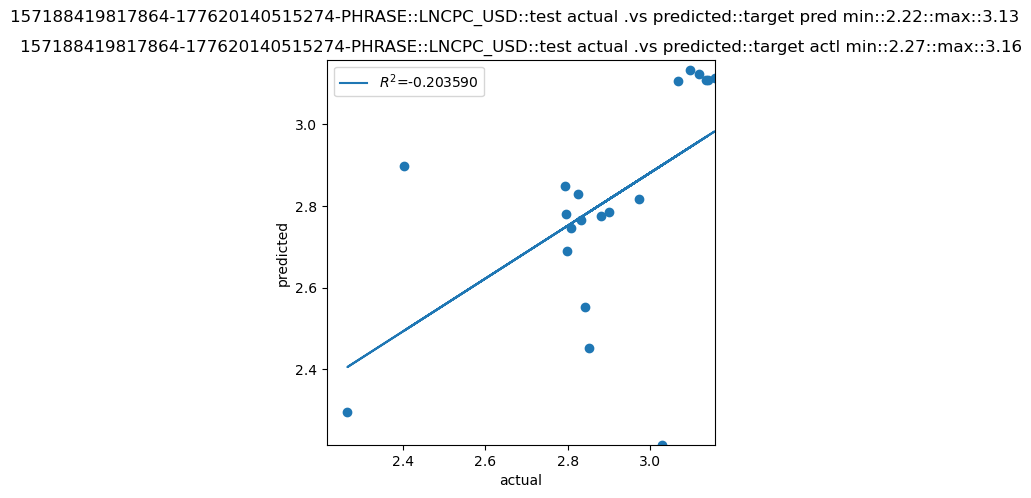


 ********** KNN model saved at KNNModelsDistanceWeighing/20221123_157188419817864_177620140515274_PHRASE_CPC_USD_KNNModel.pickle **********
********** AKM metadata Dictionary saved at KNNModelsDistanceWeighing/20221123_157188419817864_177620140515274_PHRASE_CPC_USD_KNNModel.json ********** 



In [6]:
df_all_metrics = knn_modeling.main()

In [7]:
df_all_metrics

,akm,date_range,total_records,isEnoughData_flag,at_least_one_col_zero,at_least_one_col_non_zero,all_col_zero,bestLag,best_lag_df_total_records,best_lag_df_train_records,smape_test_datalength,smape_skippedcnt,testsmape,testr2
0,157188419817864-177620140515274-PHRASE,100,100,True,50,100,0,1,99,79,20,0,5.37,-0.2
